In [5]:
# %pip install --upgrade langchain langsmith langgraph langserve langchain_openai openai python-dotenv javascript numpy genson fastapi
%reload_ext autoreload
%autoreload 2

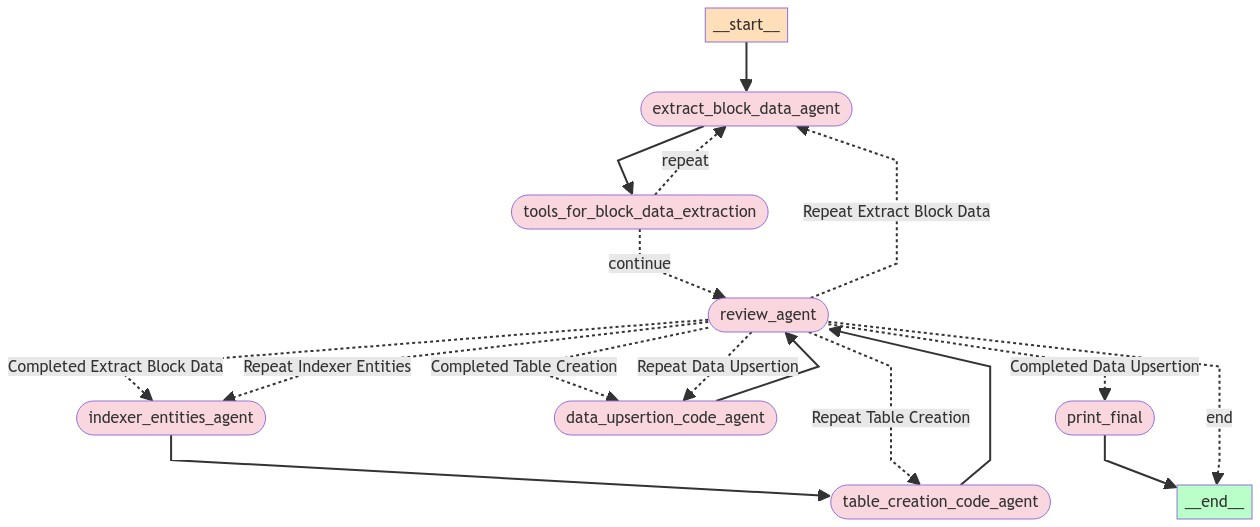

In [6]:
# Setup
from dotenv import load_dotenv
import os
from graph.master_graph import create_graph, create_graph_no_human_review
from IPython.display import Image, display

# Load .env file
load_dotenv('.env')

# Set model variables
OPENAI_BASE_URL = "https://api.openai.com/v1"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_ORGANIZATION = os.getenv("OPENAI_ORGANIZATION")

# Set environment variables
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

# Create Graph
workflow = create_graph()
# workflow = create_graph_no_human_review()
app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [7]:
# Define question and invoke app
from langchain_core.messages import HumanMessage

question = """
    Extract all FunctionCalls where receiverId is 'app.nearcrowd.near'. For each function call, I need signerId, block height, receiptId, block datetime, methodName. 
    Also add all fields from args that are decoded from base64-encoded JSON. I only need actions for successful receipts. 
    Use block height 119688212 for parsing the JS code, and only pull data from the last 2 days 
    """

inputs = {
    "messages":[HumanMessage(content=question)],
    "original_prompt":question,
    "block_heights":[],
    "entity_schema": "",
    "block_data_extraction_code":"",
    "table_creation_code":"",
    "data_upsertion_code": "",
    "indexer_entities_description":"",
    "iterations": 0,
    "error":"",
    "should_continue": False,
    }

# RUN MASTER APP
result = app.invoke(inputs)
table_creation_code = result['table_creation_code'].replace("\\n","\n")
block_data_extraction_code = result['block_data_extraction_code'].replace("\\n","\n")
data_upsertion_code = result['data_upsertion_code'].replace("\\n","\n")

Calling tool: tool_infer_schema_of_js
Reviewing code...
Code is not valid. Repeating: Extract Block Data.
Calling tool: tool_js_on_block_schema_func
Reviewing code...
Completed Extract Block Data
Identify key entities
Generating Table Creation Code
Reviewing code...
Completed Table Creation
Generating Data Upsertion Code
Reviewing code...
Completed Data Upsertion
Table Creation Code: 
                                                         CREATE TABLE function_calls (\n    id SERIAL PRIMARY KEY,\n    signer_id VARCHAR,\n    block_height BIGINT,\n    receipt_id VARCHAR,\n    block_datetime VARCHAR,\n    method_name VARCHAR,\n    task_ordinal BIGINT,\n    task_hash BIGINT[]\n);
                                                         Data Upsertion Code: 
                                                         import * as primitives from "@near-lake/primitives";
async function getBlock(block) {
    async function extractData(block) {
        const results = [];
        try {
         

In [4]:
print(f'SQL DDL: {table_creation_code}')
print(f'Data Upsertion Logic: {data_upsertion_code}')

SQL DDL: CREATE TABLE account (
    account_id VARCHAR PRIMARY KEY
);

CREATE TABLE block (
    block_height BIGINT PRIMARY KEY,
    block_datetime VARCHAR,
    timestamp_nanosec BIGINT
);

CREATE TABLE receipt (
    receipt_id VARCHAR PRIMARY KEY,
    receiver_id VARCHAR,
    status VARCHAR
);

CREATE TABLE function_call (
    id SERIAL PRIMARY KEY,
    signer_id VARCHAR,
    block_height BIGINT REFERENCES block(block_height),
    receipt_id VARCHAR REFERENCES receipt(receipt_id),
    block_datetime VARCHAR,
    method_name VARCHAR,
    task_ordinal BIGINT,
    task_hash BIGINT[]
);
Data Upsertion Logic: import * as primitives from "@near-lake/primitives";

async function getBlock(block) {
    function base64decode(encodedValue) {
        let buff = Buffer.from(encodedValue, 'base64');
        return JSON.parse(buff.toString('utf-8'));
    }

    const successfulReceipts = block.receipts()
        .filter(receipt => receipt.receiverId === 'app.nearcrowd.near')
        .filter(receipt 